In [209]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import butter, filtfilt, medfilt

In [211]:
def define_energy(signal: np.ndarray, frame_length, hop_length) -> np.ndarray:
    # Tính toán năng lượng của từng frame trong tín hiệu
    energy = np.array([
        np.sum(np.abs(signal[i:i+frame_length])**2)
        for i in range(0, len(signal), hop_length)
    ])  
    return energy

def find_voice_index(signal: np.ndarray, frame_length, hop_length, thresh=0.005) -> list:
    # Tính năng lượng cho từng khung
    energy = define_energy(signal, frame_length, hop_length)

    # Tránh chia cho 0 trong trường hợp năng lượng toàn bộ là 0
    if max(energy) > 0:
        energy_norm = energy / max(energy)
    else:
        energy_norm = energy
    # Tìm các index mà năng lượng vượt ngưỡng
    index_voices = np.where(energy_norm >= thresh)[0].tolist()
    return index_voices


In [212]:
# # Hàm tìm F0 bằng phương pháp HPS
def find_f0(signal, sample_rate, min_freq=60, max_freq=400, N_FFT=2048):
    # Áp dụng cửa sổ Hamming để làm mượt tín hiệu
    windowed_signal = signal * np.hamming(len(signal))
    
    # Thực hiện FFT và chỉ lấy phổ biên độ
    fft_N_points = np.fft.fft(windowed_signal, N_FFT)
    spectrum = 2.0/N_FFT * np.abs(fft_N_points[:N_FFT//2])
    frequencies_N_points = sample_rate * np.arange(N_FFT//2) / N_FFT
    
    # Giới hạn tần số trong khoảng quan tâm (80Hz - 400Hz)
    valid_freqs = (frequencies_N_points >= min_freq) & (frequencies_N_points <= max_freq)
    frequencies_N_points = frequencies_N_points[valid_freqs]
    spectrum = spectrum[valid_freqs]
    # Áp dụng HPS (Harmonic Product Spectrum)
    hps_spectrum = np.copy(spectrum)

    # Nhân phổ với các bội số 2, 3, 4,...
    for h in range(2, 4):
        # Downsample bằng cách sử dụng phép nội suy để lấy phổ tương ứng
        downsampled_spectrum = np.interp(
            np.arange(0, len(spectrum), h),  # Các giá trị sau khi nội suy
            np.arange(0, len(spectrum)),     # Các giá trị ban đầu
            spectrum                        # Phổ gốc
        )
        
        # Đảm bảo các phổ có cùng độ dài trước khi nhân
        min_len = min(len(hps_spectrum), len(downsampled_spectrum))
        hps_spectrum[:min_len] *= downsampled_spectrum[:min_len]
        log_spectrum = np.log(np.abs(spectrum) + np.finfo(float).eps)  # Thêm epsilon để tránh log(0)
        
    # Tìm tần số có biên độ lớn nhất sau khi áp dụng HPS
    peak_index = np.argmax(log_spectrum)
    peak_freq = frequencies_N_points[peak_index]
    return peak_freq

In [213]:
# Hàm tạo bộ lọc thông thấp
def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Hàm tính F0 cho từng frame dựa trên các index_voices
def calculate_f0_per_frame(x, index_voices, frame_length, hop_length, sr, kernel_size=7, cutoff_freq=230):
    f0_values = []
    time_values = []
    energy = define_energy(x, frame_length, hop_length)
    for idx in range(len(energy)):
        start = idx * hop_length
        end = start + frame_length
        frame = x[start:end]

        if len(frame) == frame_length:
            frame = frame * np.hamming(frame_length)  # Áp dụng hàm cửa sổ
            
            # Áp dụng bộ lọc thông thấp
            filtered_frame = lowpass_filter(frame, cutoff=cutoff_freq, fs=sr)
            
            # Áp dụng bộ lọc trung vị
            filtered_frame = medfilt(filtered_frame, kernel_size=kernel_size)

            if idx in index_voices:
                # Tính F0 trên frame đã lọc
                f0 = find_f0(filtered_frame, sr)
            else:
                f0 = 0 
            f0_values.append(f0)
            time_values.append(librosa.frames_to_time(idx, sr=sr, hop_length=hop_length))
    return time_values, f0_values

In [214]:
def find_f0s(audio: np.ndarray, index_voices: list, frame_length: int, hop_length: int, sr: int) -> list:
    f0s = []  # Lưu giá trị F0 chỉ cho các frame đã xử lý

    for i in index_voices:
        start_sample_index = librosa.frames_to_samples(i, hop_length=hop_length)
        end_sample_index = start_sample_index + frame_length
        
        # Đảm bảo frame không vượt quá độ dài tín hiệu
        if end_sample_index <= len(audio): 
            frame = audio[start_sample_index:end_sample_index]
            f0 = find_f0(frame, sr, min_freq=60, max_freq=400)
            # Lưu F0 vào danh sách
            f0s.append(f0)
    return f0s

In [215]:
def split_segments(index_voices: list) -> list:
    start = index_voices[0]
    segments = []
    for i in range(1, len(index_voices)):
        if index_voices[i] - index_voices[i-1] > 1:
            segments.append((start, index_voices[i-1]))
            start = index_voices[i]
    segments.append((start, index_voices[-1]))
    return segments

In [216]:
import os
import time
def analize_audio(file_path: str, frame_length_ms, thresh=0.005) -> None:
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    frame_length = int(frame_length_ms * sr / 1000)
    hop_length = frame_length // 2
    print(f'Frame length: {frame_length}, Hop length: {hop_length}')

    # Find energy
    energy = define_energy(audio, frame_length, hop_length)
    energy_norm = energy / max(energy)
    
    t = librosa.frames_to_time(range(len(energy)), sr=sr, hop_length=hop_length)
    
    index_voices = find_voice_index(audio, frame_length, hop_length, thresh)
    # Find f0
    f0s = find_f0s(audio, index_voices, frame_length, hop_length, sr)
    segments = split_segments(index_voices)
    
    # Tính F0 cho các index_voices đã lọc
    time_values, f0_values = calculate_f0_per_frame(audio, index_voices, frame_length, hop_length, sr)


    # Plot waveform
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.plot(t, energy_norm)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy')

    plt.subplot(3, 1, 2)
    plt.scatter(time_values, f0_values, c='blue', s=2)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    # Điều chỉnh giới hạn trục y
    plt.ylim(0, 420) 

    plt.subplot(3, 1, 3)
    plt.plot(audio)
    # Đánh dấu tần số cơ bản (F0) trên đồ thị phổ tần số
    for i in segments:
        # define start and end of the segment
        start_sample_index = librosa.frames_to_samples(i[0], hop_length=hop_length)
        end_sample_index = librosa.frames_to_samples(i[1], hop_length=hop_length) + frame_length

        plt.axvline(start_sample_index, color='r')
        # fill the segment with green color
        plt.axvspan(start_sample_index, end_sample_index, color='g', alpha=0.5)
        plt.axvline(end_sample_index, color='r')
        
    plt.xlabel('Sample index')
    plt.ylabel('Amplitude')
    plt.tight_layout()  
    plt.show()
    
    # Extract base name of the audio file and change extension to .txt
    base_name = os.path.splitext(os.path.basename(file_path))[0]
    output_file = f'analysis/data/HPS_pitch_detection/{base_name}.txt'

    # Write F0 values to the generated text file
    with open(output_file, 'w') as f:
        for f0 in f0_values:
            f.write(f'{f0:.2f}\n')
    
    print(f"F0 values have been written to {output_file}")

Frame length: 480, Hop length: 240
5.348658157607256e-05


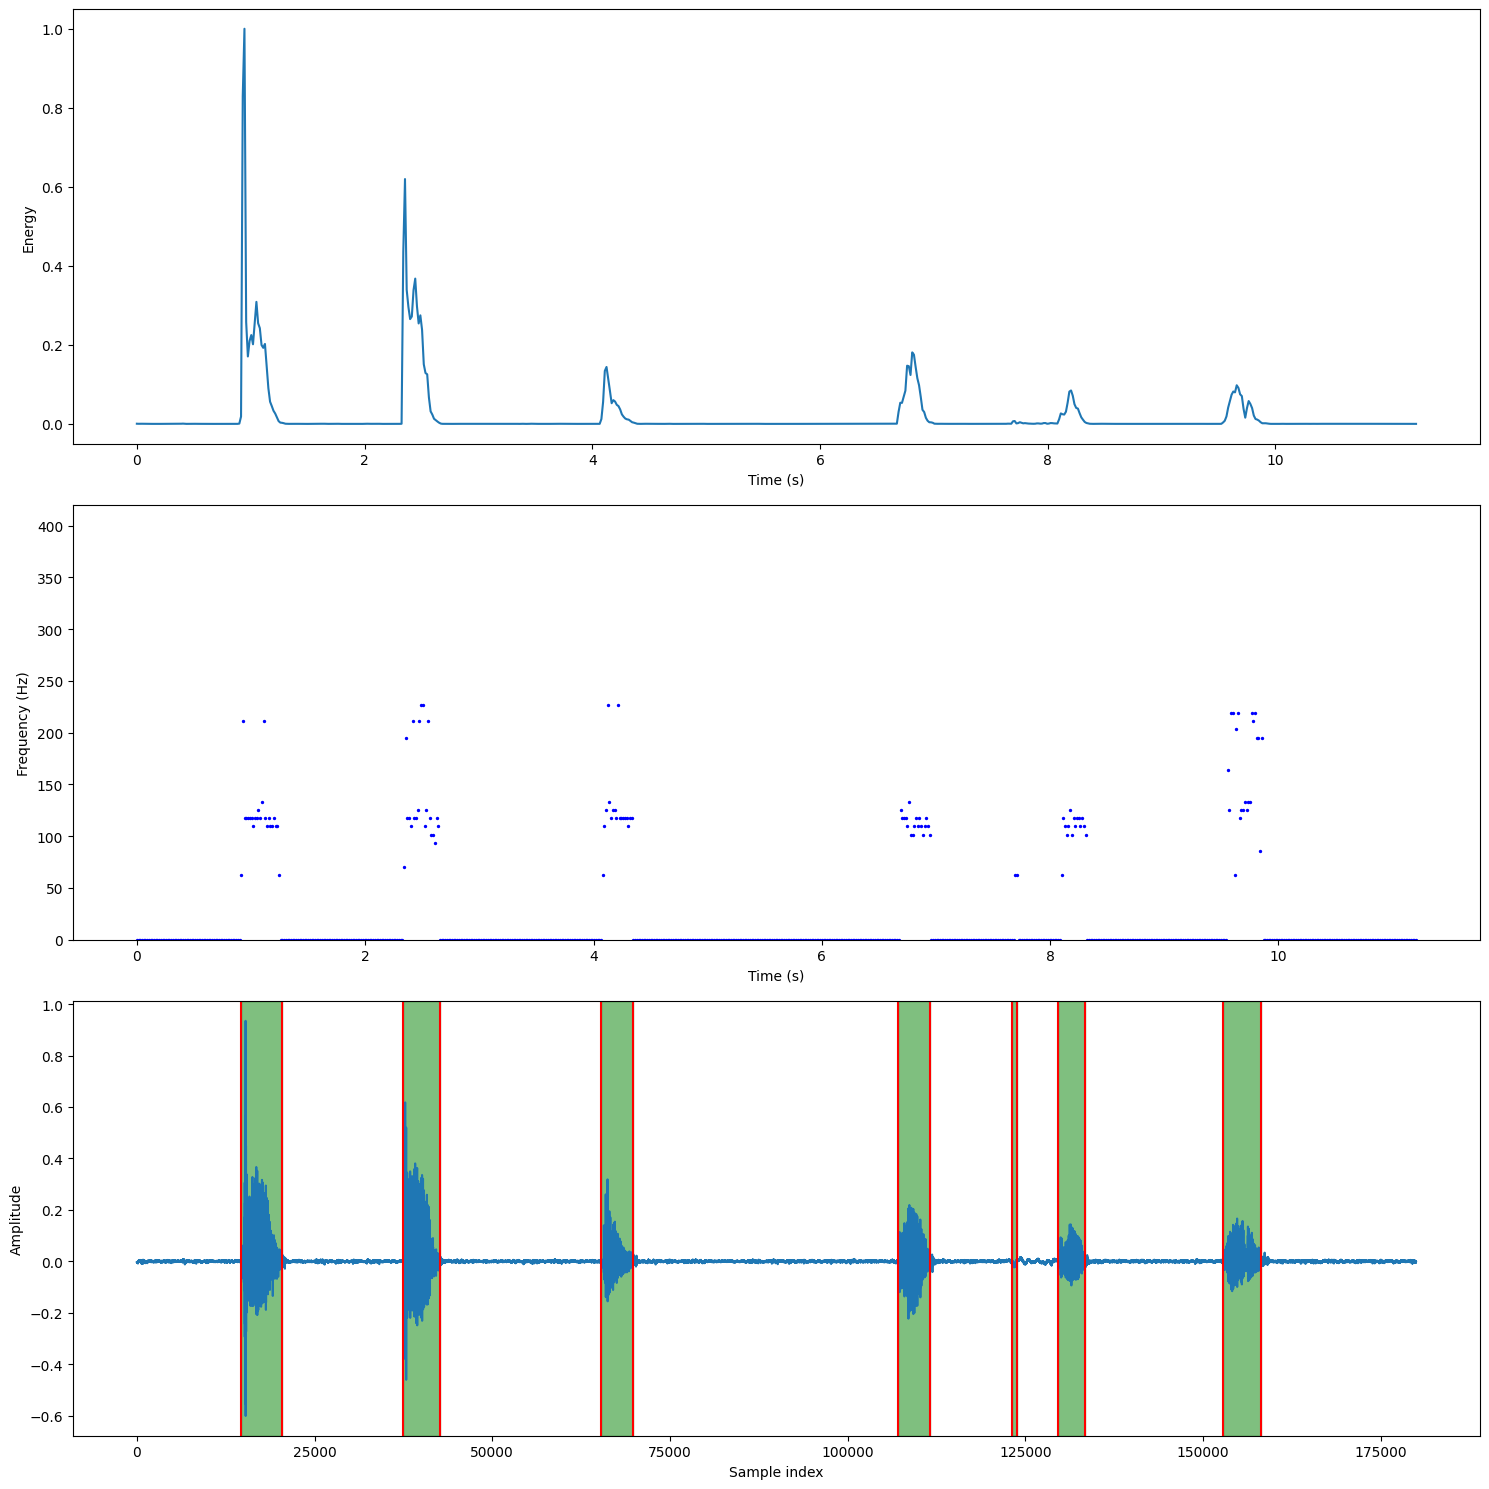

F0 values have been written to analysis/data/HPS_pitch_detection/lab_male.txt


In [217]:
analize_audio('test_signals/lab_male.wav', 30)

Frame length: 480, Hop length: 240
5.520221798918968e-05


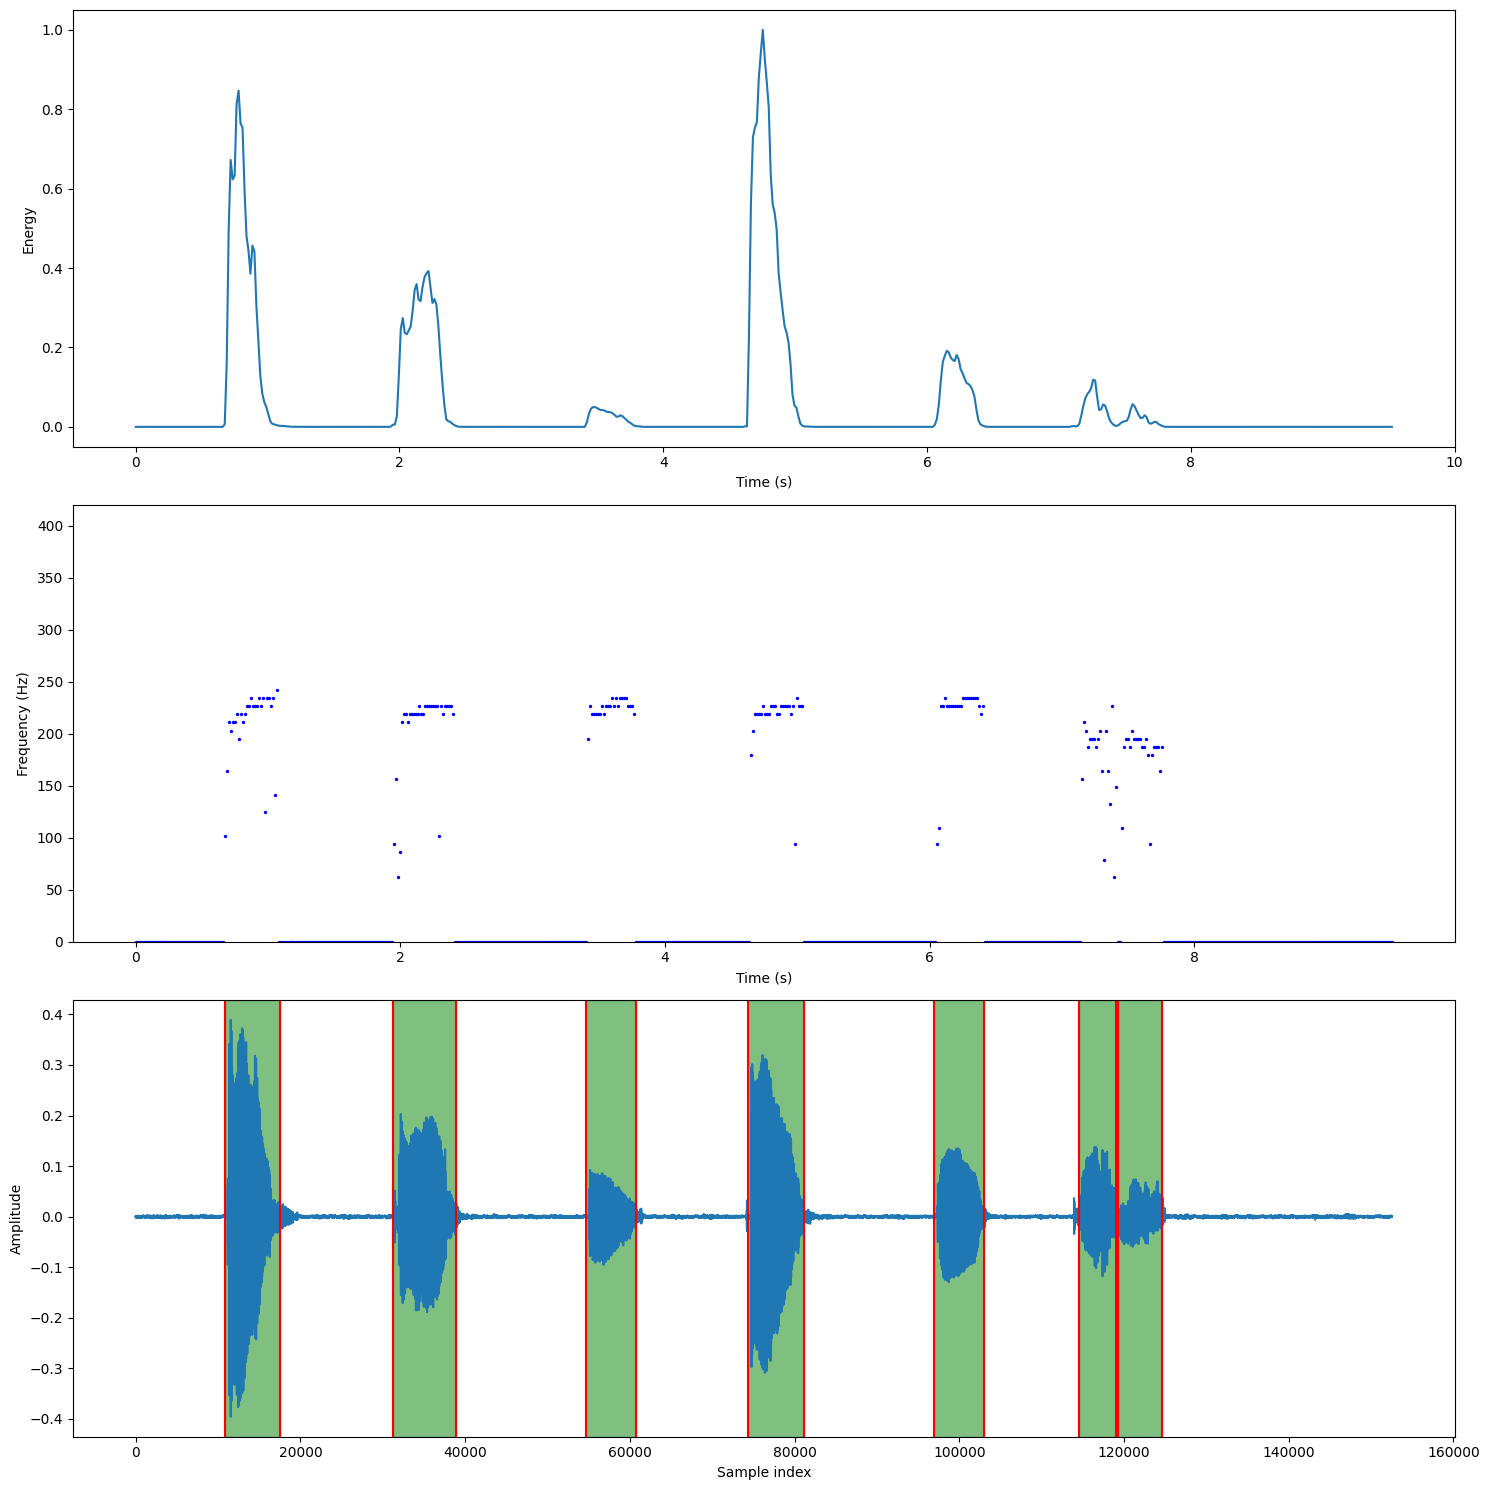

F0 values have been written to analysis/data/HPS_pitch_detection/lab_female.txt


In [218]:
analize_audio('test_signals/lab_female.wav', 30)

Frame length: 480, Hop length: 240
1.2773275375366212e-05


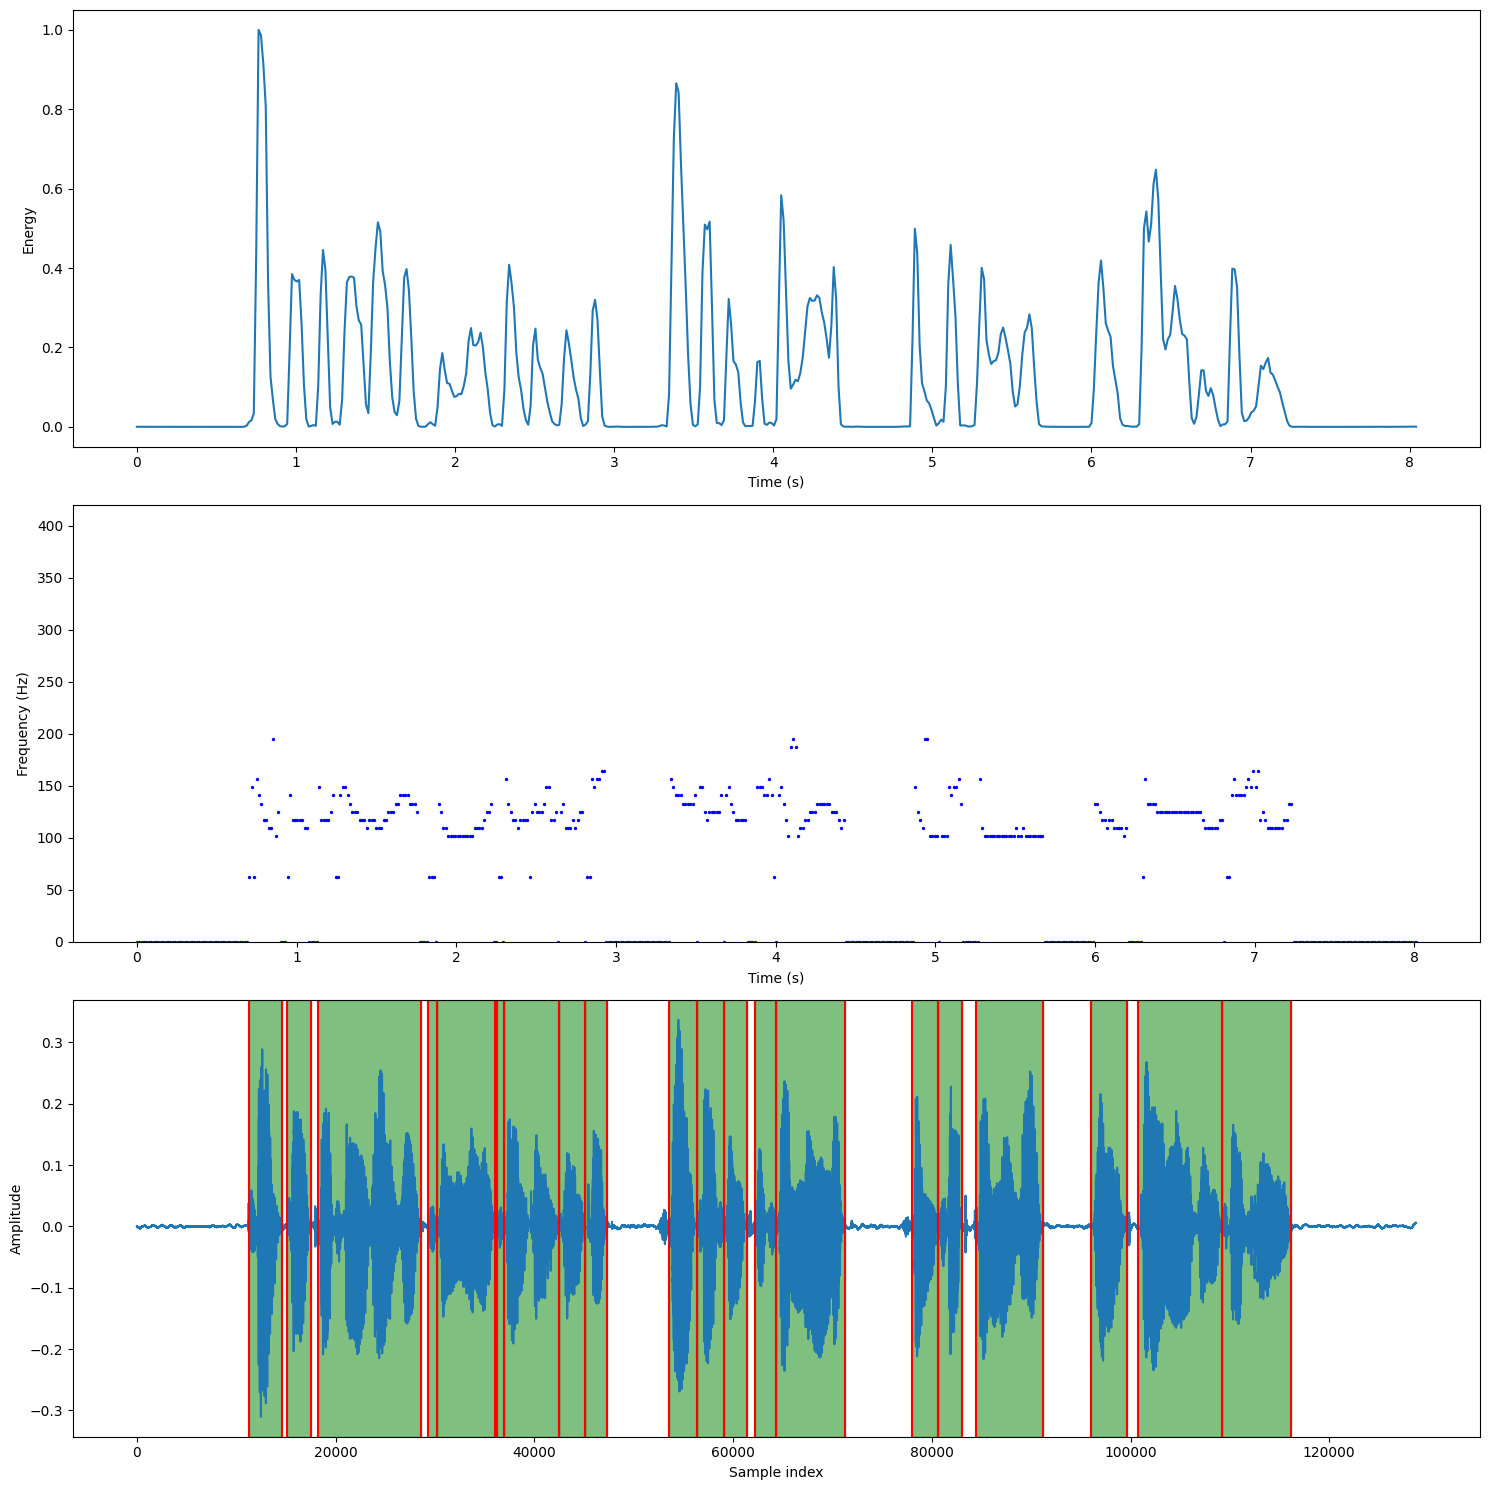

F0 values have been written to analysis/data/HPS_pitch_detection/studio_male.txt


In [219]:
analize_audio('test_signals/studio_male.wav', 30)

Frame length: 480, Hop length: 240
1.0654409095723794e-05


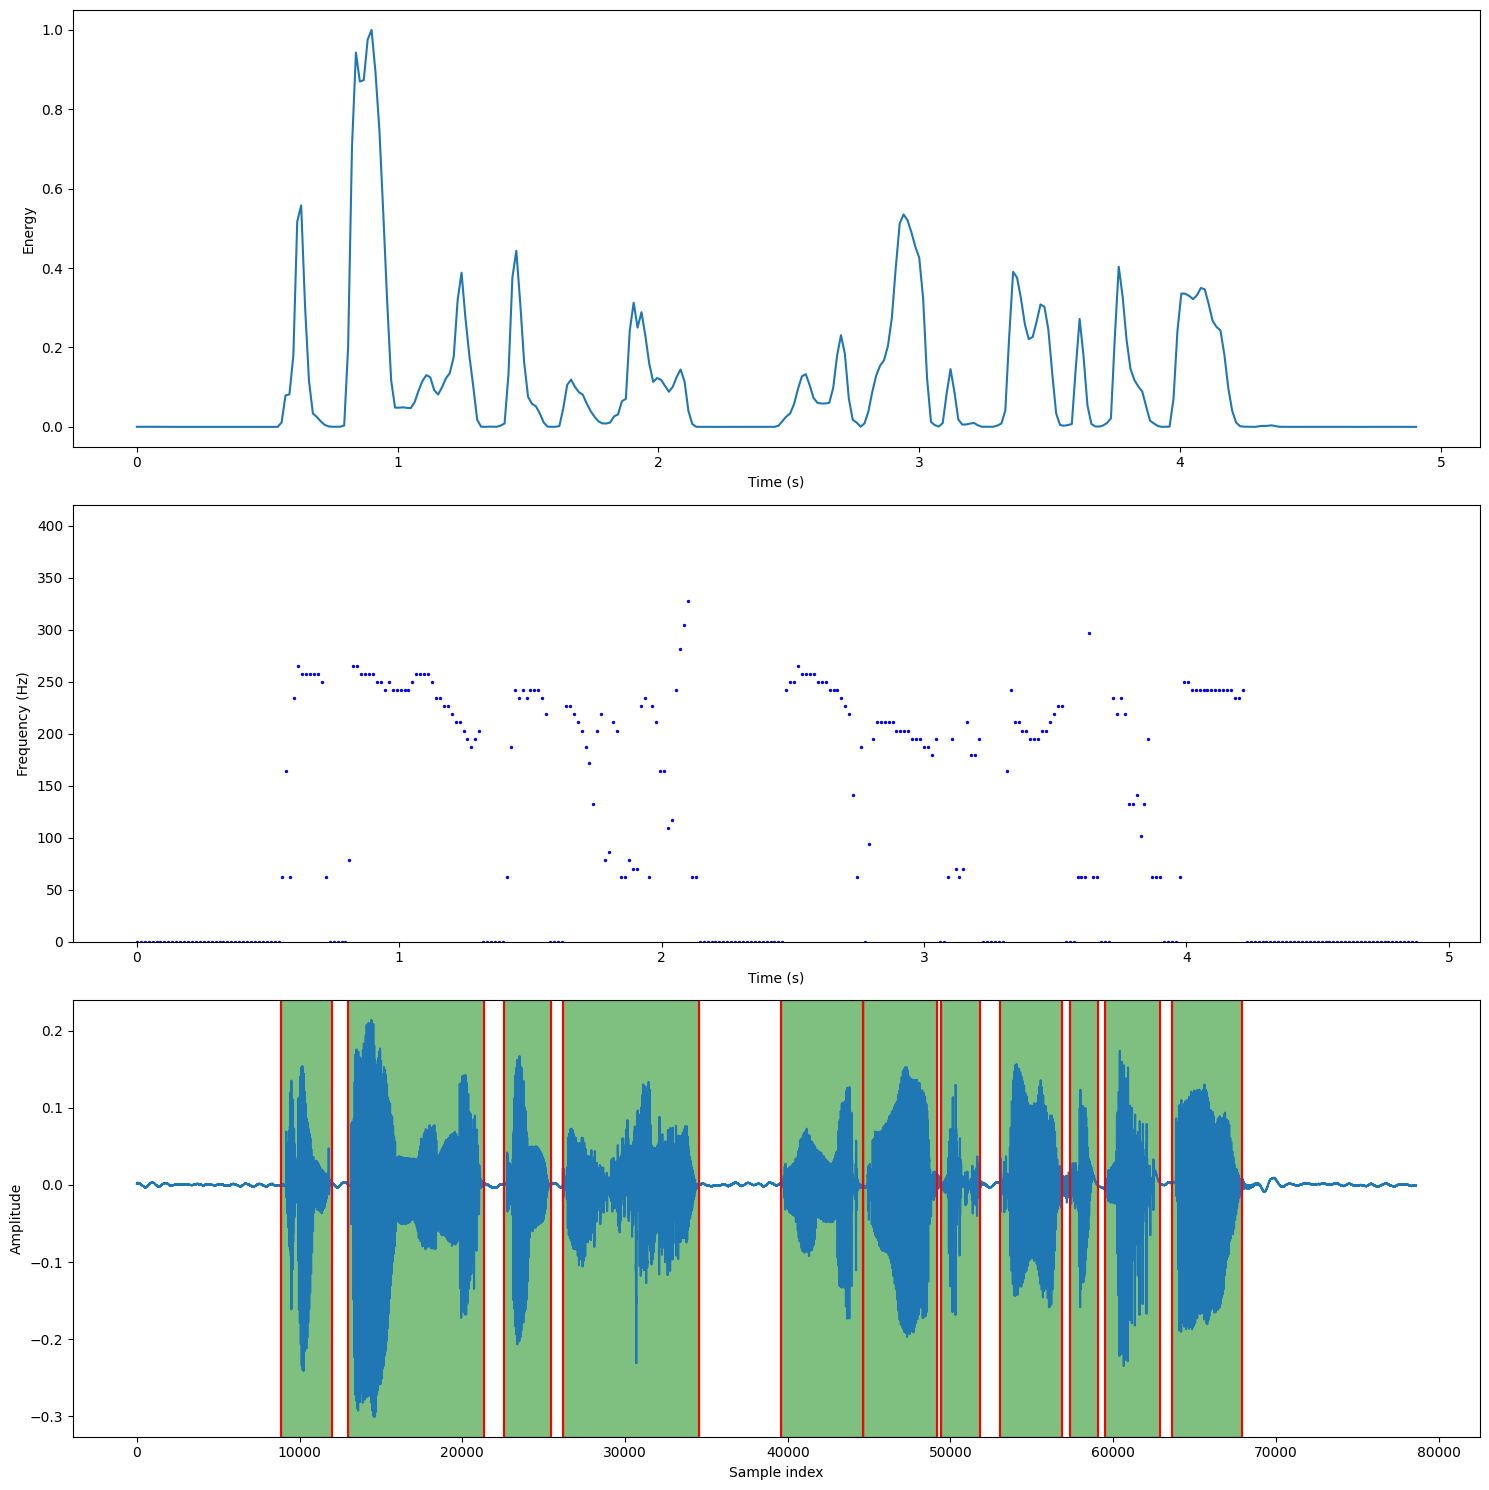

F0 values have been written to analysis/data/HPS_pitch_detection/studio_female.txt


In [220]:
analize_audio('test_signals/studio_female.wav', 30)

Frame length: 661, Hop length: 330
8.737564086914063e-06


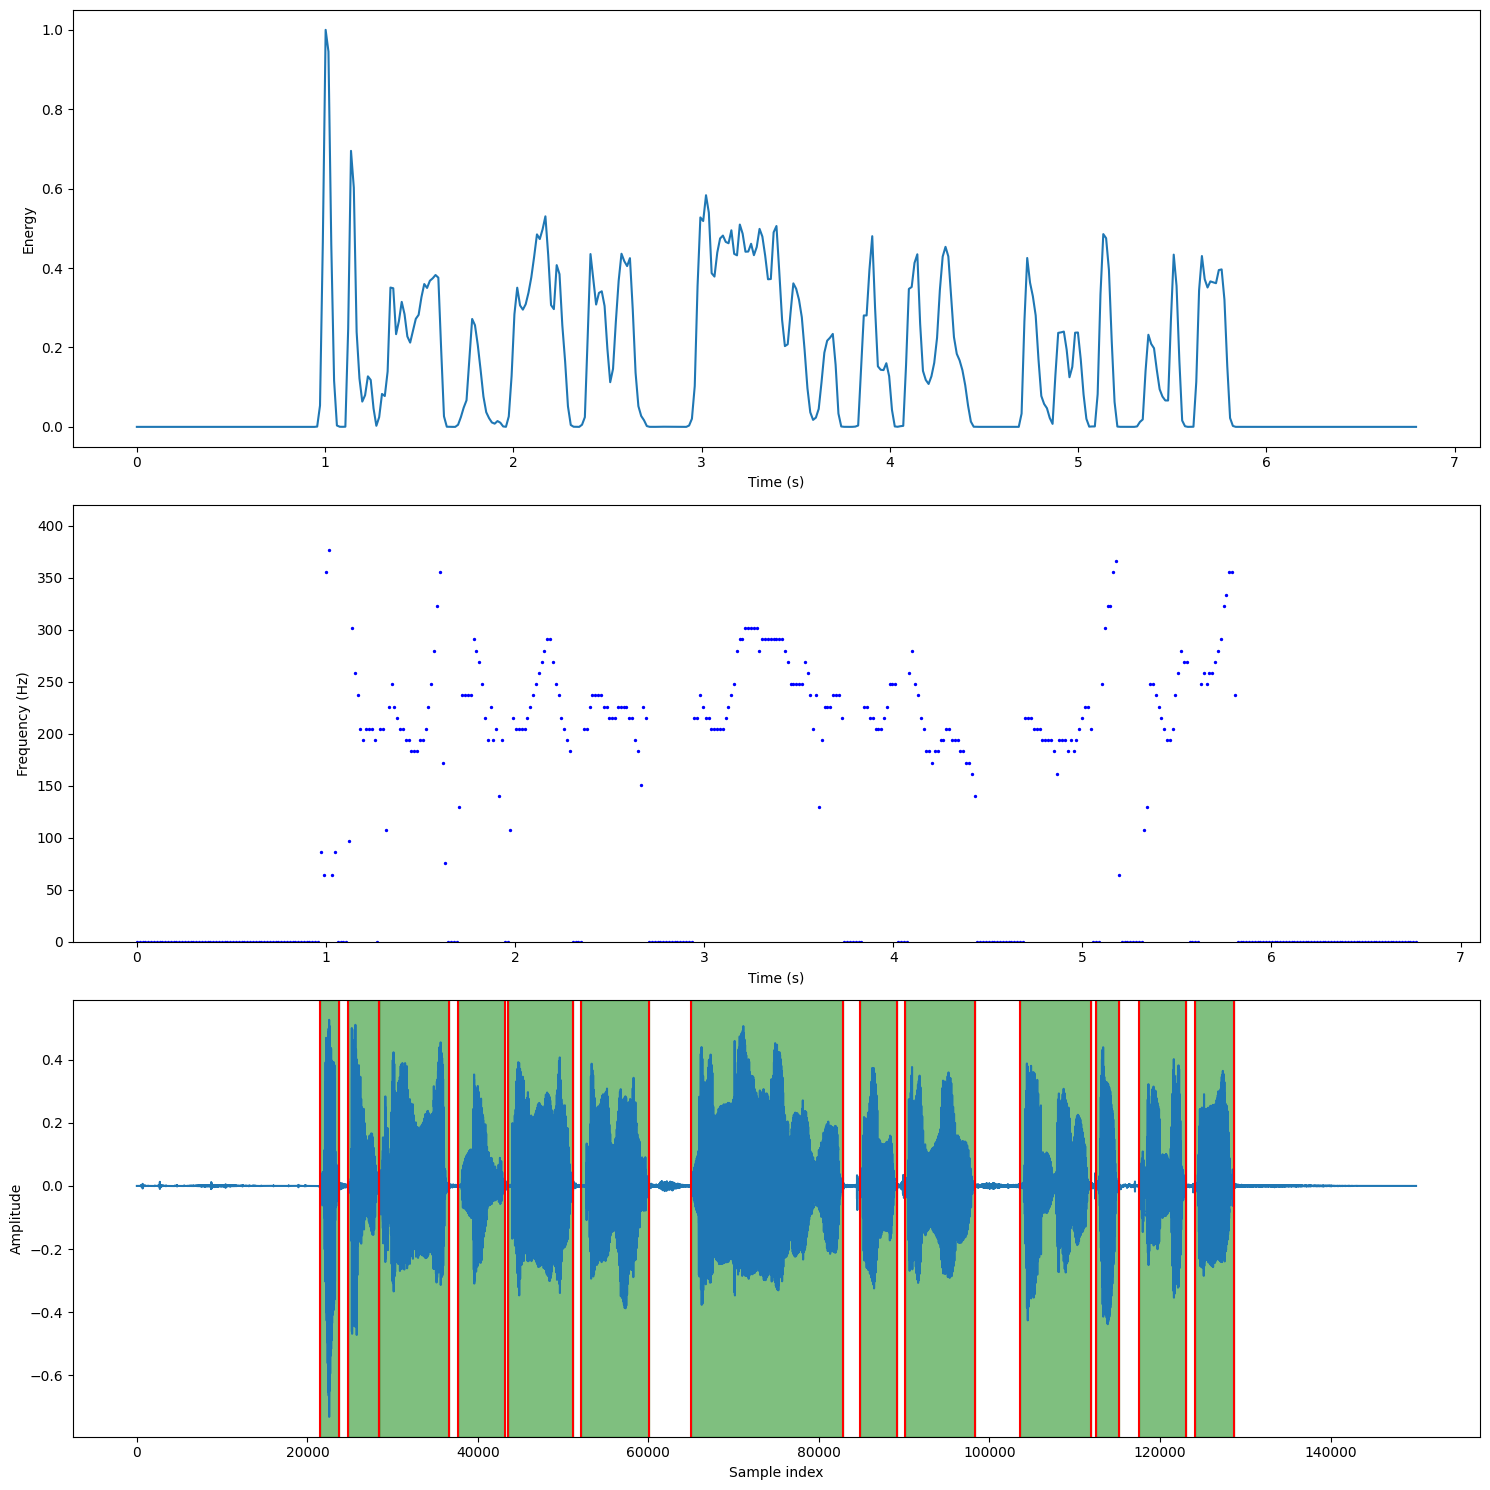

F0 values have been written to analysis/data/HPS_pitch_detection/FHU_RE_005.txt


In [221]:
analize_audio('test_signals/FHU_RE_005.wav', 30)

Frame length: 661, Hop length: 330
0.0


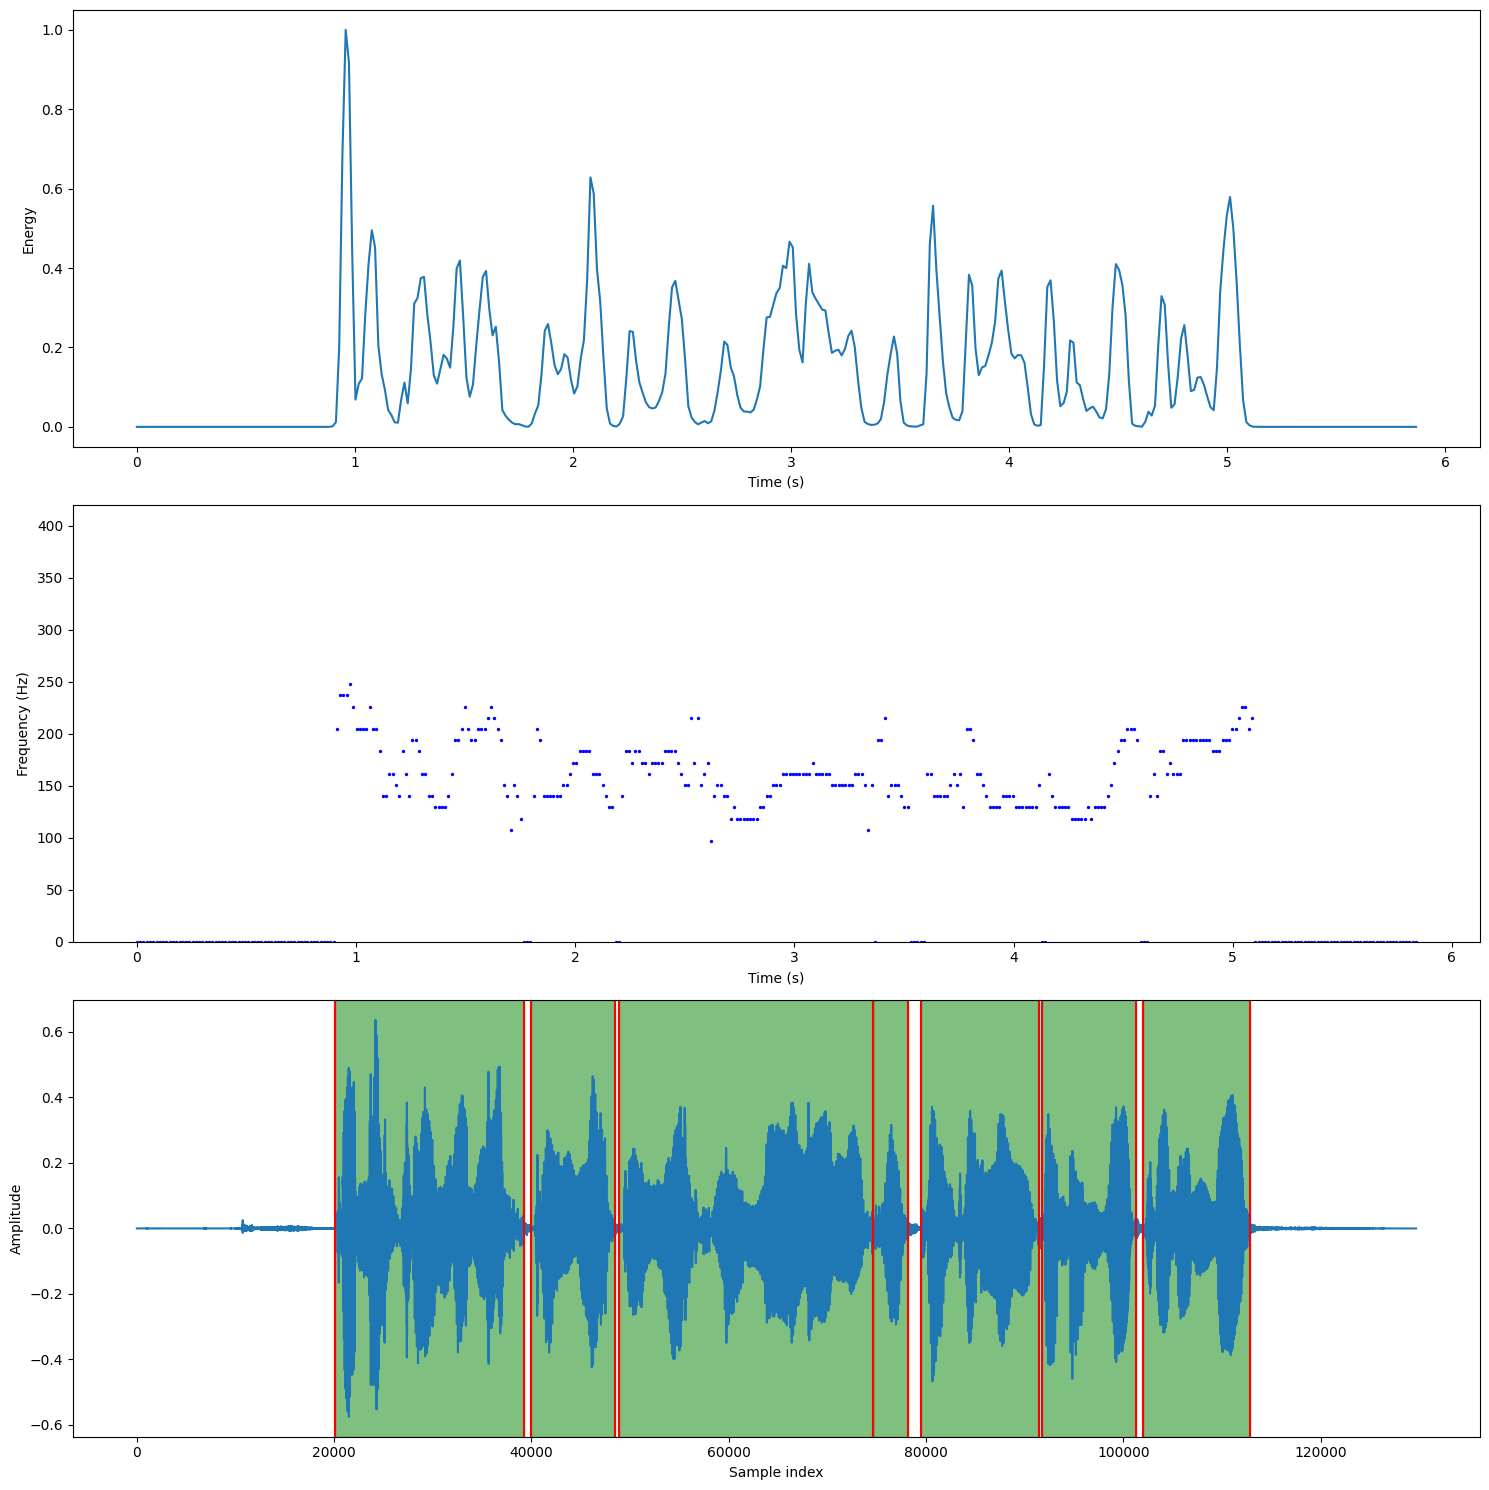

F0 values have been written to analysis/data/HPS_pitch_detection/MDU_RE_005.txt


In [222]:
analize_audio('test_signals/MDU_RE_005.wav', 30)